Epoch 1/5


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 42917.5586 - mean_absolute_percentage_error: 77.0329 - val_loss: 3087.3279 - val_mean_absolute_percentage_error: 26.7364 - learning_rate: 0.0100
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4941.4888 - mean_absolute_percentage_error: 27.5608 - val_loss: 2350.1833 - val_mean_absolute_percentage_error: 22.7105 - learning_rate: 0.0099
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4851.4634 - mean_absolute_percentage_error: 24.2860 - val_loss: 2184.7988 - val_mean_absolute_percentage_error: 20.2312 - learning_rate: 0.0098
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4036.2310 - mean_absolute_percentage_error: 21.9793 - val_loss: 2206.9673 - val_mean_absolute_percentage_error: 19.9738 - learning_rate: 0.0097
Epoch 5/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4283.0815 - mean_absolute_percentage_error: 21.9627 - val_loss: 2222.5005 - val_mean_absolute_percentage_error: 20.5339 - learning_rate: 0

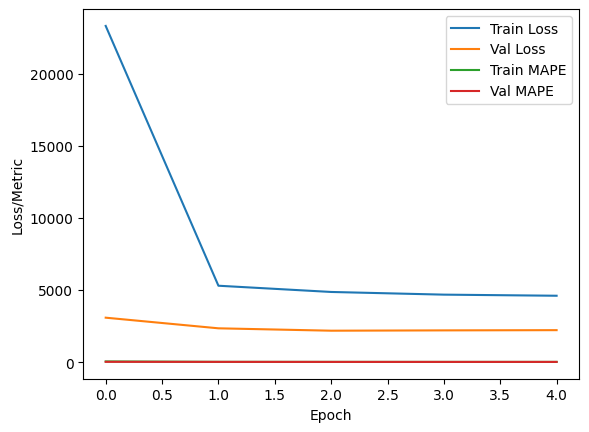

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE on validation set: 20.23%
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

# Function to prepare data
def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    
    # Replace NaNs using KNN Imputer
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 'IsWeekend']
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    
    # One-hot encode categorical features
    warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe')
    day_dummies = pd.get_dummies(data['DayOfWeek'], prefix='Day')
    month_dummies = pd.get_dummies(data['Month'], prefix='Month')
    
    # Combine all features
    feature_df = pd.concat([data[numerical_cols], warengruppe_dummies, day_dummies, month_dummies], axis=1)
    return feature_df

# Prepare datasets
X_train = prepare_data(df_train)
y_train = df_train['Umsatz']
X_test = prepare_data(df_test)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# NO RANDOM SPLIT FOR TIMESERIES DATA!
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Learning rate scheduler function
def lr_schedule(epoch, lr):
    initial_lr = 0.01  # Start with this learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 10  # Epochs after which to decay
    return initial_lr * np.exp(-decay_rate * (epoch / decay_steps))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Build the model
model = tf.keras.Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mean_absolute_percentage_error'])

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=5, # was 150
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Val MAPE')
plt.xlabel('Epoch')
plt.ylabel('Loss/Metric')
plt.legend()
plt.show()

# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation set
val_predictions = model.predict(X_val).flatten()
val_mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_val, val_predictions).numpy()
print(f'MAPE on validation set: {val_mape:.2f}%')

# Make predictions on test set and save results
test_predictions = model.predict(X_test).flatten()
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)